# [Домашнє завдання до модуля «Класифікація зображень»](https://www.edu.goit.global/learn/25315460/26519706/26520588/homework)

## Dataset: [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

### Imports & Config

In [1]:
import os, random, json, time, copy, math, warnings, itertools
from pathlib import Path
from tempfile import TemporaryDirectory

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix, f1_score

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

tmp_dir_ctx = TemporaryDirectory()
MODEL_DIR = Path(tmp_dir_ctx.name) / "ckpt"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Checkpoints are saved in: {MODEL_DIR}")

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoints are saved in: /tmp/tmpsy4xgbaa/ckpt


In [2]:
class CFG:
    seed = 42
    img_size = 150
    train_bs = 32
    valid_bs = 32
    num_workers = 12
    epochs = 10
    lr = 1e-3
    weight_decay = 1e-4
    step_size = 3
    gamma = 0.5
    patience = 3
    num_classes = 6
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data_root = os.path.expanduser("~/Projects/DataSets/GoIT/intel")
    model_dir = Path("models")
    model_dir.mkdir(exist_ok=True)
    best_model_cnn_path = model_dir / "best_cnn.pth"
    best_resnet_frozen_path = model_dir / "best_resnet18.pth"
    best_resnet_finetune_path = model_dir / "best_resnet18_ft.pth"

print(f"Using device: {CFG.device}")

Using device: cuda


In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(CFG.seed)

### Data \& Transforms

In [4]:
train_tf = transforms.Compose(
    [
        transforms.RandomResizedCrop((CFG.img_size, CFG.img_size), scale=(0.75, 1.25)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
        transforms.RandomAutocontrast(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

valid_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_dir = CFG.data_root + "/seg_train/seg_train"
valid_dir = train_dir

test_dir = CFG.data_root + "/seg_test/seg_test"

full_train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
class_names = full_train_ds.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Number of training samples: {len(full_train_ds)}")
print(f"Number of validation samples: {len(full_train_ds)}")
print(f"Number of test samples: {len(full_train_ds)}")
print(f"Class distribution: {dict(zip(class_names, [full_train_ds.targets.count(i) for i in range(len(class_names))]))}")


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6
Number of training samples: 14034
Number of validation samples: 14034
Number of test samples: 14034
Class distribution: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


In [6]:
val_fraction = 0.2
val_size = int(val_fraction*len(full_train_ds))
train_size = len(full_train_ds)-val_size

train_ds, val_ds = random_split(full_train_ds,[train_size,val_size],generator=torch.Generator().manual_seed(CFG.seed))
val_ds.dataset.transform = valid_tf

test_ds  = datasets.ImageFolder(test_dir, transform=valid_tf)

train_loader = DataLoader(train_ds, batch_size=CFG.train_bs, shuffle=True,  num_workers=CFG.num_workers)
val_loader   = DataLoader(val_ds,   batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers)
test_loader  = DataLoader(test_ds,  batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

Train/Val/Test sizes: 11228/2806/3000


## Custom CNN

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x
    
model_custom_cnn = SimpleCNN(num_classes=CFG.num_classes).to(CFG.device)
print(model_custom_cnn)
print(f"Number of parameters: {sum(p.numel() for p in model_custom_cnn.parameters() if p.requires_grad)}")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### Loss, Optimiser, Scheduler, EarlyStopping

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_custom_cnn.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)

In [9]:
class EarlyStopper:
    def __init__(self, patience: int = 3, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
    def step(self, val_loss: float):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        self.counter += 1
        return self.counter >= self.patience
    
early_stopper = EarlyStopper(patience=CFG.patience)

### Train / Validate helpers

In [10]:
@torch.no_grad()
def compute_metrics(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        logits = model(x)
        y_pred.extend(torch.argmax(logits, 1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
    report = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)
    return report, cm


def train_epoch(model, loader, optimizer):
    model.train()
    running_loss, correct = 0.0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)


def validate_epoch(model, loader):
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
    return val_loss / len(loader.dataset), correct / len(loader.dataset)


def train_model(model, train_loader, val_loader, optimizer, scheduler, file_name):
    train_hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = np.inf
    for epoch in range(1, CFG.epochs + 1):
        tl, ta = train_epoch(model, train_loader, optimizer)
        vl, va = validate_epoch(model, val_loader)
        scheduler.step()
        train_hist["train_loss"].append(tl)
        train_hist["val_loss"].append(vl)
        train_hist["train_acc"].append(ta)
        train_hist["val_acc"].append(va)
        print(f"Epoch {epoch:02d}/{CFG.epochs} | tl {tl:.3f} vl {vl:.3f} | acc {ta*100:.1f}/{va*100:.1f}")
        if vl < best_val_loss:
            best_val_loss = vl
            torch.save(model.state_dict(), file_name)
        if early_stopper.step(vl):
            print("Early stopping")
            break
        
    return train_hist

### Training Loop

In [11]:
train_hist_custom_cnn = train_model(model_custom_cnn, train_loader, val_loader, optimizer, scheduler, CFG.best_model_cnn_path)

Epoch 01/10 | tl 0.937 vl 0.666 | acc 63.2/74.3


Epoch 02/10 | tl 0.698 vl 1.299 | acc 74.1/55.7


Epoch 03/10 | tl 0.636 vl 0.566 | acc 76.5/79.4


Epoch 04/10 | tl 0.560 vl 0.499 | acc 79.3/80.8


Epoch 05/10 | tl 0.522 vl 0.456 | acc 80.9/83.0


Epoch 06/10 | tl 0.497 vl 0.652 | acc 81.6/75.8


Epoch 07/10 | tl 0.455 vl 0.393 | acc 83.2/85.6


Epoch 08/10 | tl 0.439 vl 0.402 | acc 84.3/84.7


Epoch 09/10 | tl 0.430 vl 0.395 | acc 84.5/85.4


Epoch 10/10 | tl 0.402 vl 0.366 | acc 85.4/87.1


### Evaluation on Test Set

In [12]:
def plot_confusion_matrix(cm, class_names):
    """ Plot confusion matrix using seaborn """
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix – Custom CNN")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


def plot_loss(train_hist):
    """ Plot training and validation loss """
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_hist["train_loss"], "b-", label="Training Loss")
    plt.plot(train_hist["val_loss"], "r-", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_hist["train_acc"], "b-", label="Training Accuracy")
    plt.plot(train_hist["val_acc"], "r-", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_all_histories(histories, labels):
    """Plot training and validation loss and accuracy for multiple models."""
    plt.figure(figsize=(16, 6))

    # Loss
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist["train_loss"], label=f"{label} Train Loss")
        plt.plot(hist["val_loss"], linestyle="--", label=f"{label} Val Loss")
    plt.title("Comparison of Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist["train_acc"], label=f"{label} Train Acc")
        plt.plot(hist["val_acc"], linestyle="--", label=f"{label} Val Acc")
    plt.title("Comparison of Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def compare_reports(reports, labels):
    """ Compare classification reports of different models """
    # metrics = ["precision", "recall", "f1-score", "accuracy"]
    summary = {}

    for report, label in zip(reports, labels):
        macro_avg = report["macro avg"]
        summary[label] = {
            "Precision": macro_avg["precision"],
            "Recall": macro_avg["recall"],
            "F1-Score": macro_avg["f1-score"],
            "Accuracy": report["accuracy"],
        }

    df_summary = pd.DataFrame(summary).T
    return df_summary


def visualize_predictions(model, dataloader, class_names, num_images=5):
    """ Visualize predictions of the model on a few images """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(CFG.device)
            labels = labels.to(CFG.device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far >= num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images // 5 + 1, 5, images_so_far)
                ax.axis("off")
                ax.set_title(
                    f"Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}"
                )
                
                # Denormalize image for display
                inv_normalize = transforms.Normalize(
                    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show() 

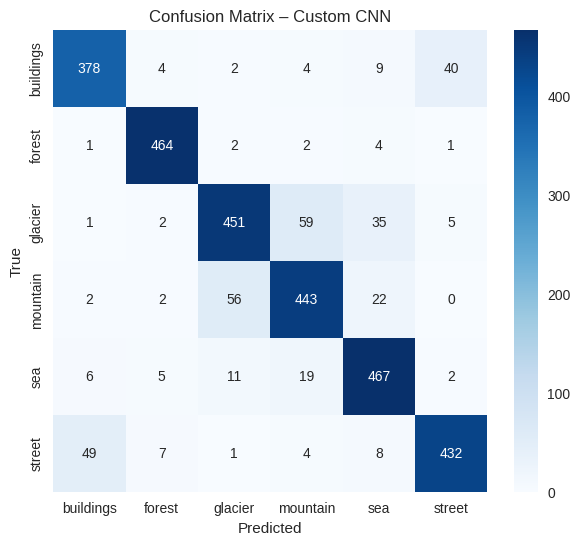

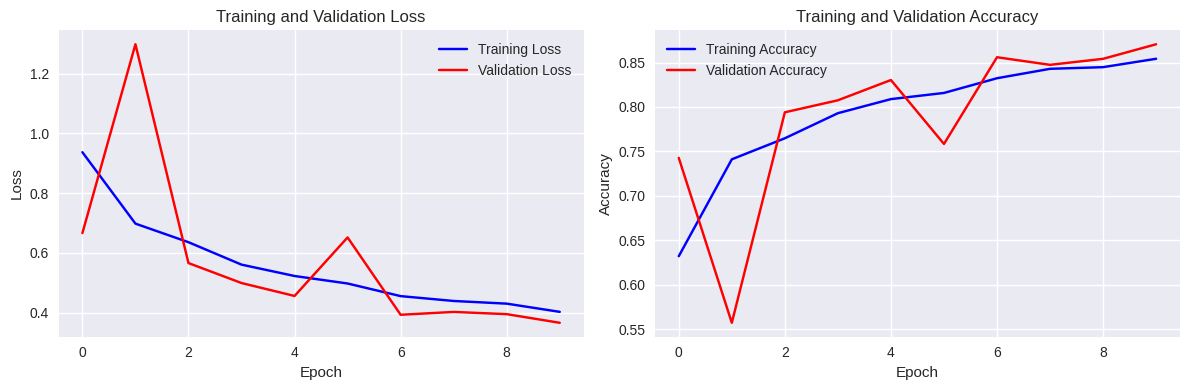

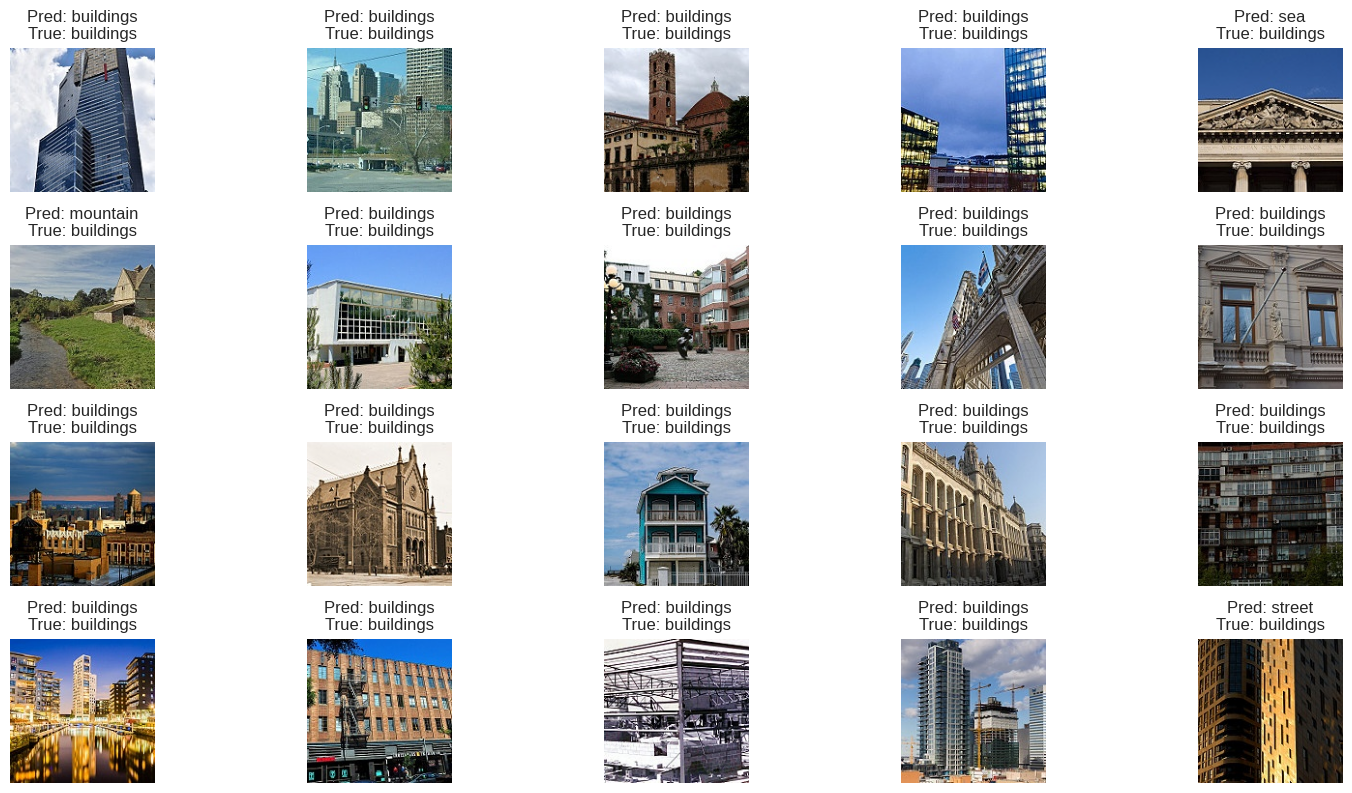

{
  "buildings": {
    "precision": 0.8649885583524027,
    "recall": 0.8649885583524027,
    "f1-score": 0.8649885583524027,
    "support": 437.0
  },
  "forest": {
    "precision": 0.9586776859504132,
    "recall": 0.9789029535864979,
    "f1-score": 0.9686847599164927,
    "support": 474.0
  },
  "glacier": {
    "precision": 0.8623326959847036,
    "recall": 0.8155515370705244,
    "f1-score": 0.8382899628252788,
    "support": 553.0
  },
  "mountain": {
    "precision": 0.8342749529190208,
    "recall": 0.8438095238095238,
    "f1-score": 0.8390151515151515,
    "support": 525.0
  },
  "sea": {
    "precision": 0.8568807339449541,
    "recall": 0.9156862745098039,
    "f1-score": 0.885308056872038,
    "support": 510.0
  },
  "street": {
    "precision": 0.9,
    "recall": 0.8622754491017964,
    "f1-score": 0.8807339449541285,
    "support": 501.0
  },
  "accuracy": 0.8783333333333333,
  "macro avg": {
    "precision": 0.8795257711919158,
    "recall": 0.880202382738425,
    "f1-

In [13]:
model_custom_cnn.load_state_dict(torch.load(CFG.best_model_cnn_path))
report_custom_cnn, cm_custom_cnn = compute_metrics(model_custom_cnn, test_loader)

plot_confusion_matrix(cm_custom_cnn, class_names)
plot_loss(train_hist_custom_cnn)
visualize_predictions(model_custom_cnn, test_loader, class_names, num_images=20)
print(json.dumps(report_custom_cnn, indent=2))

## Transfer Learning – ResNet‑18

### Load imagenet-pretrained weights model and config

In [14]:
resnet_freeze_all = models.resnet18(weights="IMAGENET1K_V1")

for param in resnet_freeze_all.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
in_features = resnet_freeze_all.fc.in_features
resnet_freeze_all.fc = nn.Linear(in_features, CFG.num_classes)
resnet_freeze_all = resnet_freeze_all.to(CFG.device)

print(resnet_freeze_all.fc)

Linear(in_features=512, out_features=6, bias=True)


In [15]:
resnet_retrain = models.resnet18(weights="IMAGENET1K_V1")

for name, param in resnet_retrain.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True

in_features = resnet_retrain.fc.in_features
resnet_retrain.fc = nn.Linear(in_features, CFG.num_classes)
resnet_retrain = resnet_retrain.to(CFG.device)

print(resnet_retrain.fc)

Linear(in_features=512, out_features=6, bias=True)


### Define loss, optimizer (only new params), scheduler

In [16]:
criterion_all = nn.CrossEntropyLoss()

optimizer_freeze_all = optim.Adam(resnet_freeze_all.fc.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler_freeze_all = optim.lr_scheduler.StepLR(optimizer_freeze_all, step_size=CFG.step_size, gamma=CFG.gamma)

optimizer_retrain = optim.Adam(
    [
        {"params": resnet_retrain.fc.parameters(), "lr": 5e-4},
        {"params": resnet_retrain.layer3.parameters(), "lr": 1e-5},
        {"params": resnet_retrain.layer4.parameters(), "lr": 1e-5},
    ],
    weight_decay=1e-4,
)
scheduler_retrain = optim.lr_scheduler.StepLR(optimizer_retrain, step_size=CFG.step_size, gamma=CFG.gamma)

### Training Loop

In [17]:
train_hist_resnet_freeze_all = train_model(resnet_freeze_all, train_loader, val_loader, optimizer_freeze_all, scheduler_freeze_all, CFG.best_resnet_frozen_path)

Epoch 01/10 | tl 0.709 vl 0.408 | acc 77.9/86.8


Epoch 02/10 | tl 0.403 vl 0.345 | acc 86.6/88.3


Epoch 03/10 | tl 0.358 vl 0.325 | acc 87.8/88.5


Epoch 04/10 | tl 0.337 vl 0.314 | acc 88.0/89.0


Epoch 05/10 | tl 0.331 vl 0.311 | acc 88.4/89.1


Epoch 06/10 | tl 0.325 vl 0.297 | acc 88.7/89.7


Epoch 07/10 | tl 0.315 vl 0.297 | acc 88.8/89.7


Epoch 08/10 | tl 0.312 vl 0.302 | acc 88.7/89.3


Epoch 09/10 | tl 0.307 vl 0.295 | acc 89.2/89.8


Epoch 10/10 | tl 0.306 vl 0.296 | acc 88.8/89.6


In [18]:
train_hist_resnet_retrain = train_model(resnet_retrain, train_loader, val_loader, optimizer_retrain, scheduler_retrain, CFG.best_resnet_finetune_path)

Epoch 01/10 | tl 0.487 vl 0.235 | acc 84.0/91.9


Epoch 02/10 | tl 0.221 vl 0.225 | acc 92.4/91.8


Epoch 03/10 | tl 0.157 vl 0.221 | acc 94.7/92.3


Epoch 04/10 | tl 0.109 vl 0.202 | acc 96.2/92.9


Epoch 05/10 | tl 0.084 vl 0.207 | acc 97.4/93.0


Epoch 06/10 | tl 0.064 vl 0.221 | acc 98.2/92.8


Epoch 07/10 | tl 0.054 vl 0.225 | acc 98.5/92.4
Early stopping


### Evaluate ResNet‑18 on Test Set

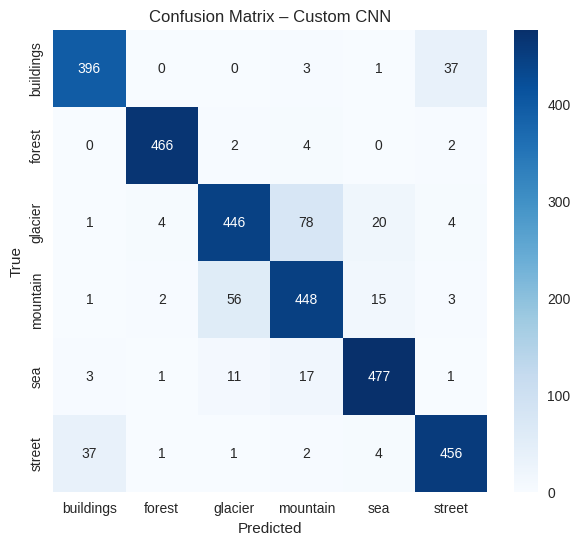

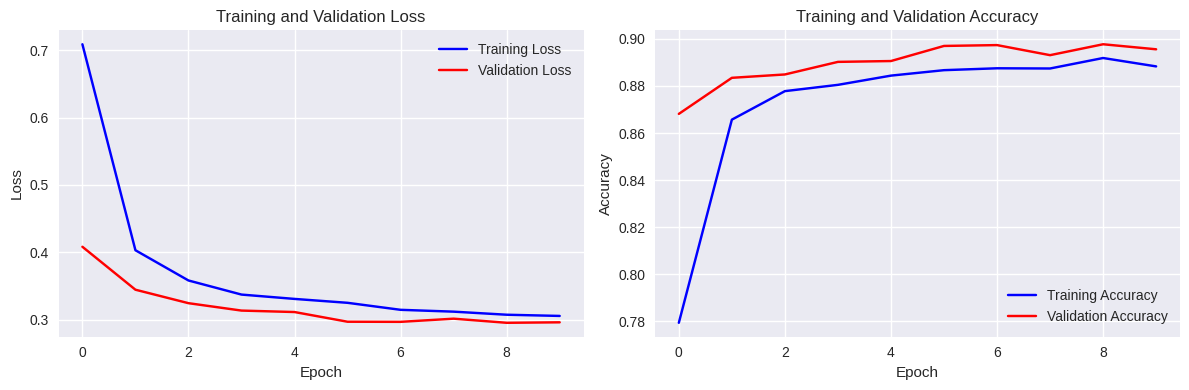

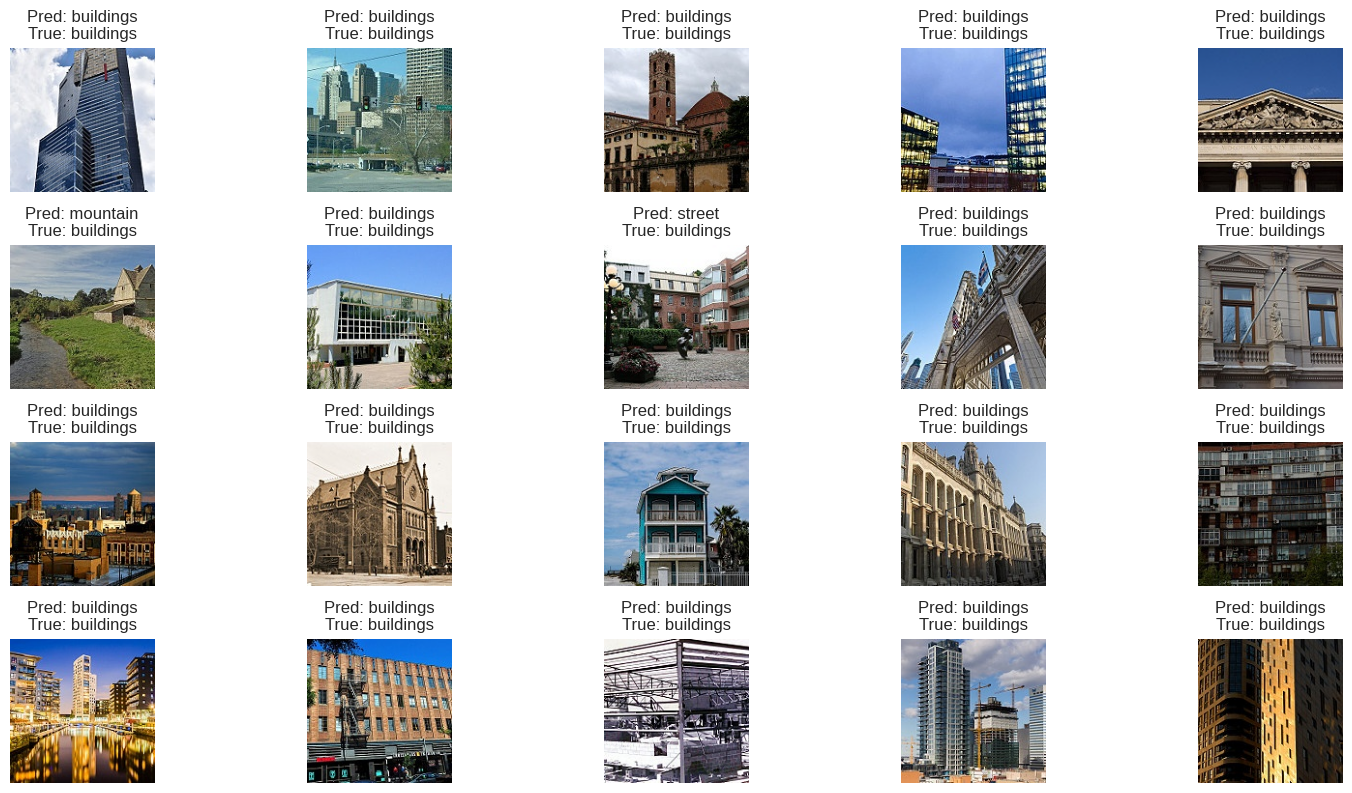

{
  "buildings": {
    "precision": 0.9041095890410958,
    "recall": 0.9061784897025171,
    "f1-score": 0.9051428571428571,
    "support": 437.0
  },
  "forest": {
    "precision": 0.9831223628691983,
    "recall": 0.9831223628691983,
    "f1-score": 0.9831223628691983,
    "support": 474.0
  },
  "glacier": {
    "precision": 0.8643410852713178,
    "recall": 0.8065099457504521,
    "f1-score": 0.8344246959775491,
    "support": 553.0
  },
  "mountain": {
    "precision": 0.8115942028985508,
    "recall": 0.8533333333333334,
    "f1-score": 0.8319405756731661,
    "support": 525.0
  },
  "sea": {
    "precision": 0.9226305609284333,
    "recall": 0.9352941176470588,
    "f1-score": 0.928919182083739,
    "support": 510.0
  },
  "street": {
    "precision": 0.9065606361829026,
    "recall": 0.9101796407185628,
    "f1-score": 0.9083665338645418,
    "support": 501.0
  },
  "accuracy": 0.8963333333333333,
  "macro avg": {
    "precision": 0.8987264061985831,
    "recall": 0.8991029816

In [19]:
resnet_freeze_all.load_state_dict(torch.load(CFG.best_resnet_frozen_path))
report_freeze_all, cm_freeze_all = compute_metrics(resnet_freeze_all, test_loader)

plot_confusion_matrix(cm_freeze_all, class_names)
plot_loss(train_hist_resnet_freeze_all)
visualize_predictions(resnet_freeze_all, test_loader, class_names, num_images=20)
print(json.dumps(report_freeze_all, indent=2))

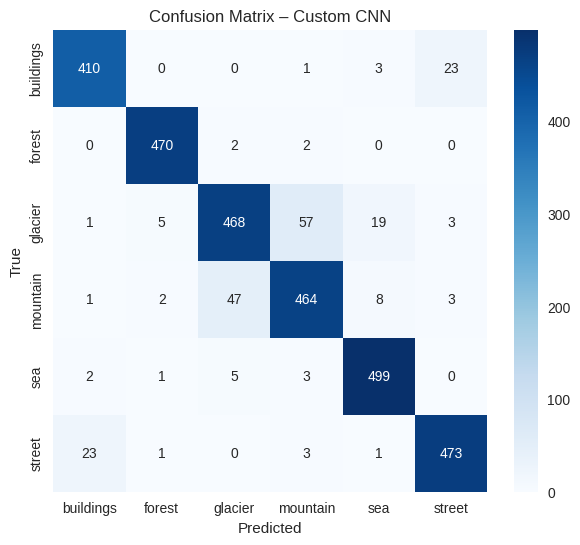

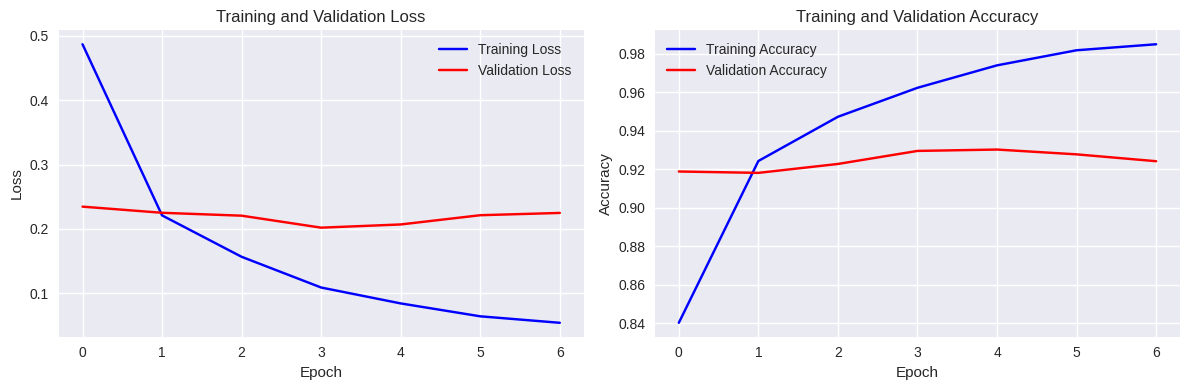

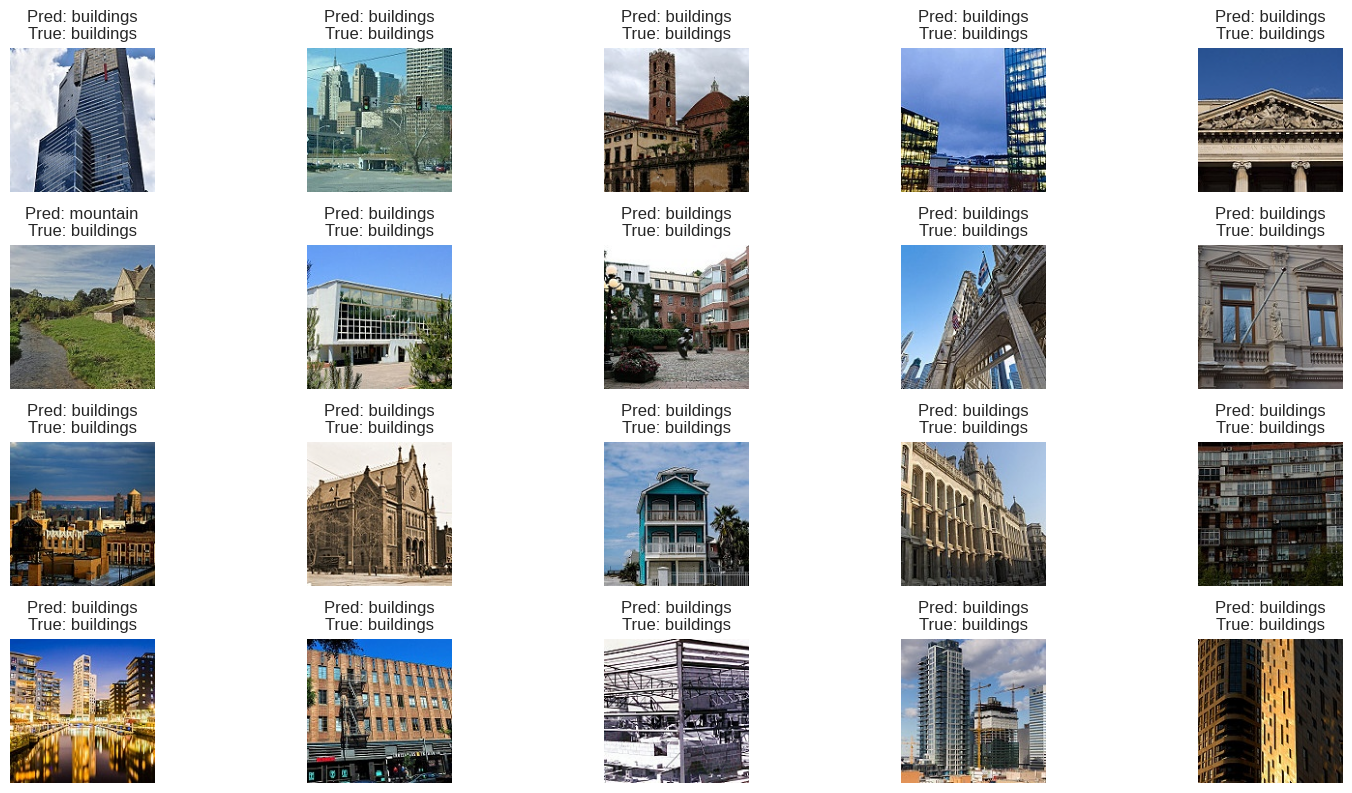

{
  "buildings": {
    "precision": 0.9382151029748284,
    "recall": 0.9382151029748284,
    "f1-score": 0.9382151029748284,
    "support": 437.0
  },
  "forest": {
    "precision": 0.9812108559498957,
    "recall": 0.9915611814345991,
    "f1-score": 0.9863588667366212,
    "support": 474.0
  },
  "glacier": {
    "precision": 0.896551724137931,
    "recall": 0.8462929475587704,
    "f1-score": 0.8706976744186047,
    "support": 553.0
  },
  "mountain": {
    "precision": 0.8754716981132076,
    "recall": 0.8838095238095238,
    "f1-score": 0.8796208530805687,
    "support": 525.0
  },
  "sea": {
    "precision": 0.9415094339622642,
    "recall": 0.9784313725490196,
    "f1-score": 0.9596153846153846,
    "support": 510.0
  },
  "street": {
    "precision": 0.9422310756972112,
    "recall": 0.9441117764471058,
    "f1-score": 0.9431704885343968,
    "support": 501.0
  },
  "accuracy": 0.928,
  "macro avg": {
    "precision": 0.929198315139223,
    "recall": 0.9304036507956414,
    "f

In [20]:
resnet_retrain.load_state_dict(torch.load(CFG.best_resnet_finetune_path))
report_retrain, cm_retrain_all = compute_metrics(resnet_retrain, test_loader)

plot_confusion_matrix(cm_retrain_all, class_names)
plot_loss(train_hist_resnet_retrain)
visualize_predictions(resnet_retrain, test_loader, class_names, num_images=20)
print(json.dumps(report_retrain, indent=2))

## Comparison

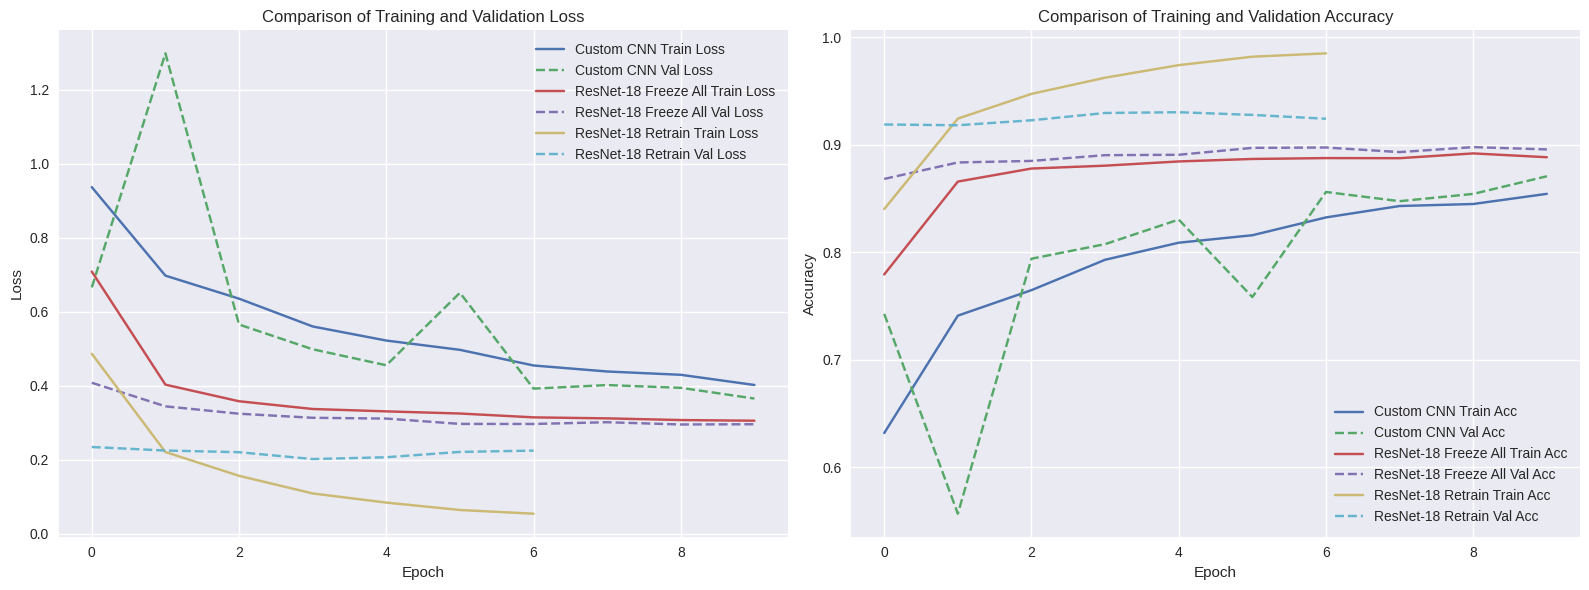

In [21]:
plot_all_histories(
    histories=[train_hist_custom_cnn, train_hist_resnet_freeze_all, train_hist_resnet_retrain],
    labels=["Custom CNN", "ResNet-18 Freeze All", "ResNet-18 Retrain"],
)

In [23]:
df_summary = compare_reports(
    reports=[report_custom_cnn, report_freeze_all, report_retrain],
    labels=["SimpleCNN", "ResNet-18 Frozen", "ResNet-18 Fine-tuned"],
)
display(df_summary)

Precision    Recall  F1-Score  Accuracy
SimpleCNN              0.879526  0.880202  0.879503  0.878333
ResNet-18 Frozen       0.898726  0.899103  0.898653  0.896333
ResNet-18 Fine-tuned   0.929198  0.930404  0.929613  0.928000

## Conclusions

Кількість епох для обох моделей = 10. 

**Simple CNN**
- Точність на базовій вибірці: 0.87
- F1-score: 0.87
- Кількість параметрів 423К
- Функція втрат зменшувалась стабільно з кожною епохою, після 10-ти епох точність моделі досягнула 0.85 на валідаційних даних. На шостій епосі можна спостерігати перенавчання. F1-score для усіх класів дорівнює 0.85 та більше окрім класів "glacier" і "mountain" (0.83-0.84).

**ResNet-18**
- Точність підвищилась на ~0.2 у порівнянні з SimpleCNN.
- Модель дуже швидко вийшла на стабільні результати точності.
- Різниця між training і validation loss/accuracy мінімальна, перенавчання не спостерігалось.
- Класи "Forest" та "sea" мають дуже високий F1 - 0.93. Клас "glacier" все ще складний для навчання.

Отже, ResNet-18 суттєво ефективніший за базову CNN завдяки заздалегідь навченим фільтрам. 
SimpleCNN є адекватною моделлю для невеликих ресурсів: менше параметрів - швидша інференція.
Виявлено слабкі місця в класифікації деяких класів ("glacier", "mountain").
Є запас для покращення ResNet-18 шляхом повного донавчання (розморозити більше шарів).
Застосування CLAHE (transforms.RandomAutocontrast) покращило точність але не набагато ~0.05
ResNet-18 - повне перенавчання дало підвищення точності +0.2.

Що можна було б ще зробити.
- SimpleCNN - додати ще одного коволюційного шару для спроби виділення складніших ознак.
- Збільшити варіації трансформацій (Cutout, Random Erasing).
- Використати циклічне навчання (CyclicLR) замість StepLR.
- Збільшити кількість епох до 20–30 із раннім зупиненням для досягнення кращої узгодженості.
